In [1]:
# uncomment unless you have sbi installed
# !pip install sbi==0.21.0

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from seaborn import histplot as hst
from scipy.stats import pearsonr as pearson
from seaborn import pairplot
import matplotlib as mpl

import torch
import sbi.utils as utils

plt.rcParams['figure.dpi'] = 600 # high resolution

# Change figure fonts easily
def change_font(label_size):
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    mpl.rcParams['font.size'] = label_size

# Set General Notebook Properties

In [2]:
import pickle

# Preparations: posterior to use
posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))

# Read desired data
def read_empirical(line, clean = False):
    if clean:
        obs = pd.read_csv(f'empirical_data/clean/{line}.csv', index_col=0)
    else:
        obs = pd.read_csv(f'empirical_data/{line}.csv', index_col=0)
    return obs

# Set a unique color for each replicate and genotype/line
color_dict_ = {'wt': ["#354f52", "#666666", "#6b705c", "#414833" ,"#999999"],
              'ltr': ["#6699cc", "#005f73", "#0a9396", "#4292C6", "#2171B5", "#3799fb", "#66b3cc"],
              'ars': ["#e26d5c","#e28f5c","#e25c6d","#da4631","#f85c46", "#bb3521","#d9402a"],
              'all': ["#ffba08", "#faa307", "#dda15e", "#7f5539", "#9c6644", "#fdc409", "#9c7e1e", "#D9BB59"],
               'lauer': ['grey' for i in range(11)]
             }
color_dict = color_dict_
color_dict['together'] = color_dict['wt']+color_dict['ltr']+color_dict['ars']+color_dict['all']
rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}

label_dict = {'wt': 'Wild type architecture', 'ltr': 'LTRs removed', 'ars': 'ARS removed', 'all': 'LTR and ARS removed', 'lauer': 'Lauer'}

# Plot Empirical Data

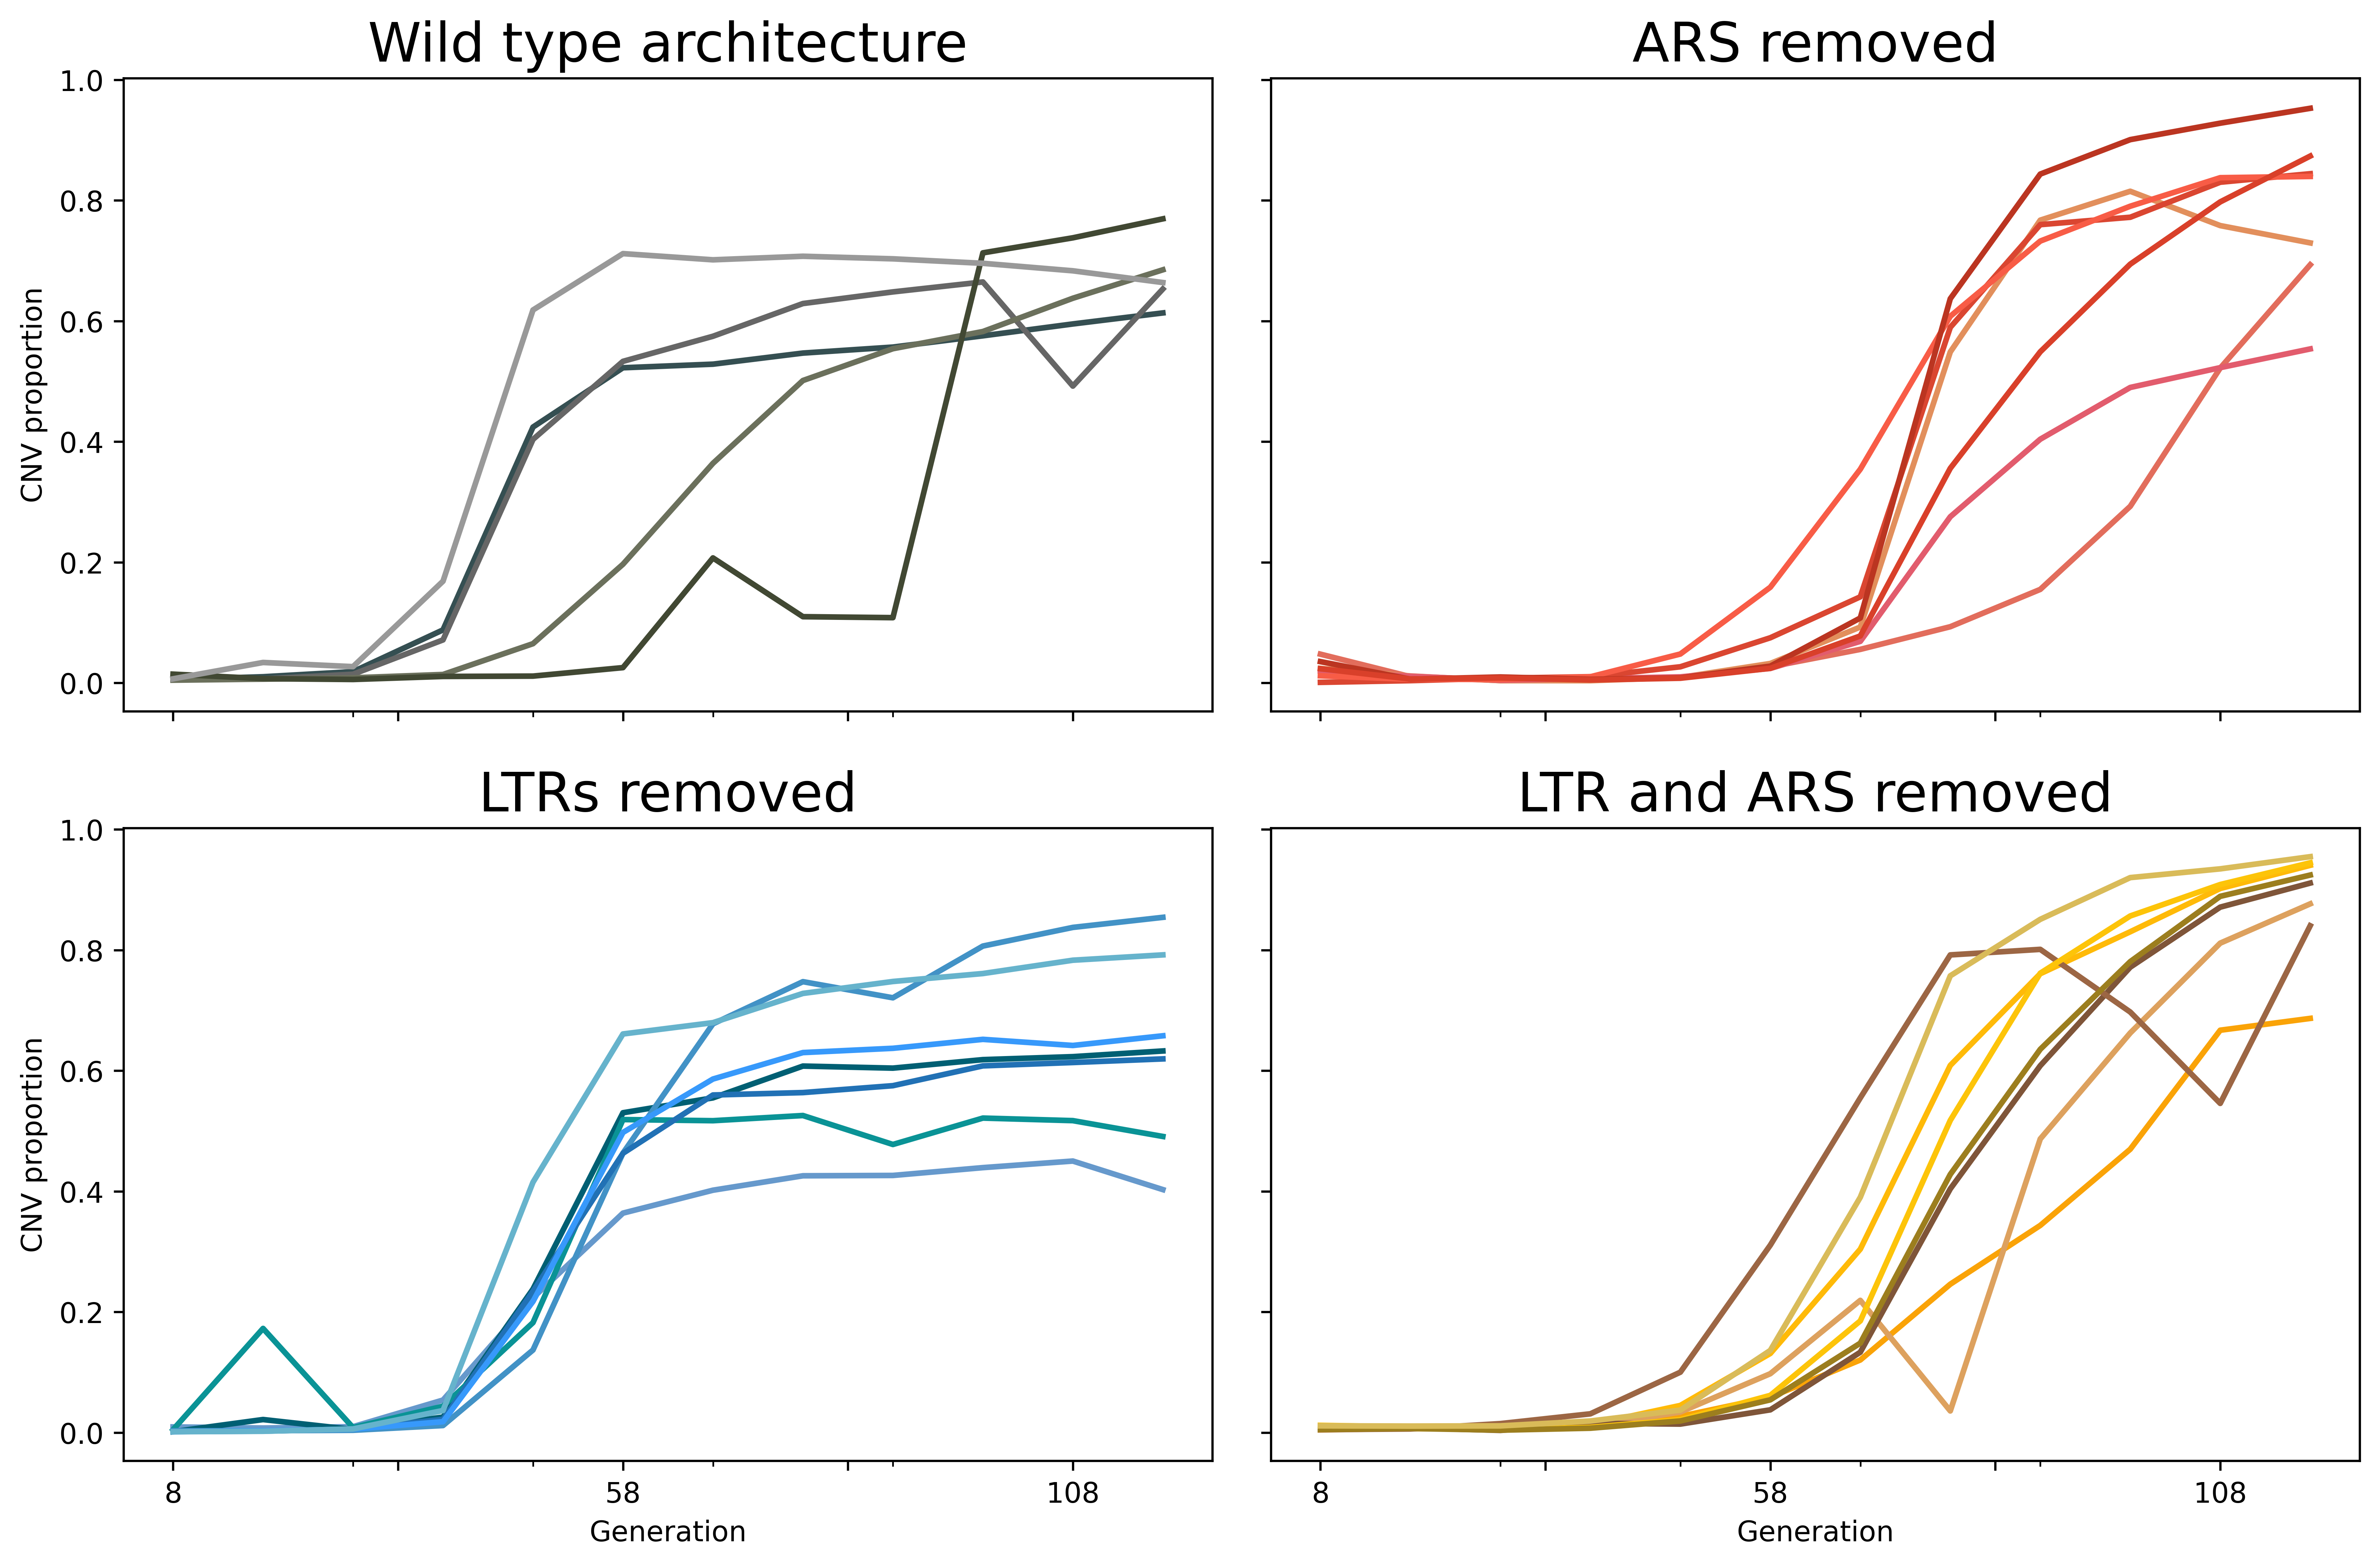

In [3]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharey=True, sharex=True, tight_layout=True)
lines = list(color_dict.keys())
font = 16
change_font(font)

for i in range(4):
    l = lines[i]
    d = read_empirical(l, clean=False)
    c = color_dict[l][0]
    d.T.plot(ax=ax[i%2, i//2], color=color_dict[l], legend = False, linewidth=2)
    ax[i%2, i//2].set_title(label_dict[l])
    ax[i%2, i//2].set_xlabel('Generation')
    ax[i%2, i//2].set_ylabel('CNV proportion')
fig.subplots_adjust(right=0.72)

# Finding MAPs (Maximum A-Posteriori)

### MAPs using sbi's implementation (unbounded)

In [4]:
from sbi.inference import MCMCPosterior
import sbi.utils as utils

# prior

prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,0.5,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))

# Get Maximum A-Posteriori (MAP) using sbi's implementation
# Using MCMC posterior as DirectPosterior (default) sometimes fails to sample
# Returns MAP values and their posterior log-density (log_prob)
def get_map(posterior,x,line):
    posterior.set_default_x(x)
    # print(f'Finding MAP for {x.name}') 
    potential_fn = posterior.potential_fn
    potential_fn.set_x(x)
    posterior_mcmc = MCMCPosterior(potential_fn, proposal = prior)
    map_value = posterior_mcmc.map(num_init_samples = 10000, num_iter = 200, show_progress_bars = False)
    return [line, posterior.log_prob(map_value).tolist()[0]] + map_value.tolist()

# Get MAPs for an entire genotype (line). 
# Each MAP is the average of several estimations (rep).
def get_maps(line, posterior, reps=1):
    obs = read_empirical(line, clean=True)
    maps = pd.DataFrame(index =  obs.index, columns = ['line', 'log_prob' ,'log(s_cnv)', 'log(m_cnv)', 'log(p_0)'])
    
    for i in range(len(obs)):
        all_res = pd.DataFrame(index = [i for i in range(reps)], columns = maps.columns)
        for r in range(reps):
            x = obs.iloc[i,:]
            print(x.name)
            x = np.array(x)
            labeled_map = get_map(posterior,x,line)
            print(labeled_map)
            all_res.iloc[r, :] = labeled_map
        all_res = all_res.groupby(['line']).mean()
        maps.iloc[i,:] = [line] + all_res.iloc[0,:].tolist()
        
    return maps

# Find MAPs for many genotypes
def create_all_maps(lines, posterior, reps):
    all_maps = get_maps(lines[0], posterior, reps = reps)
    for line in lines[1:]:
        all_maps = pd.concat([all_maps, get_maps(line, posterior, reps)])
    return all_maps

# uncomment to recreate the maps
# lines = ['wt', 'ltr', 'ars', 'all']
# maps_sbi = create_all_maps(lines, posterior_chuong, reps=1)

### Saved MAP values

In [5]:
all_maps_sbi = pd.read_csv('maps/sbi_all_maps_chuong.csv', index_col=0)
lauer_maps_sbi = pd.read_csv('maps/sbi_all_maps_lauer.csv', index_col=0)

maps_sbi = pd.concat([all_maps_sbi, lauer_maps_sbi])

# Overall posterior's MAPs and samples
overall_maps = pd.read_csv('maps/overall_maps.csv', index_col=0)
overall_samples = pd.read_csv('maps/overall_posterior_samples.csv', index_col=0)

# Comparison of MAP values

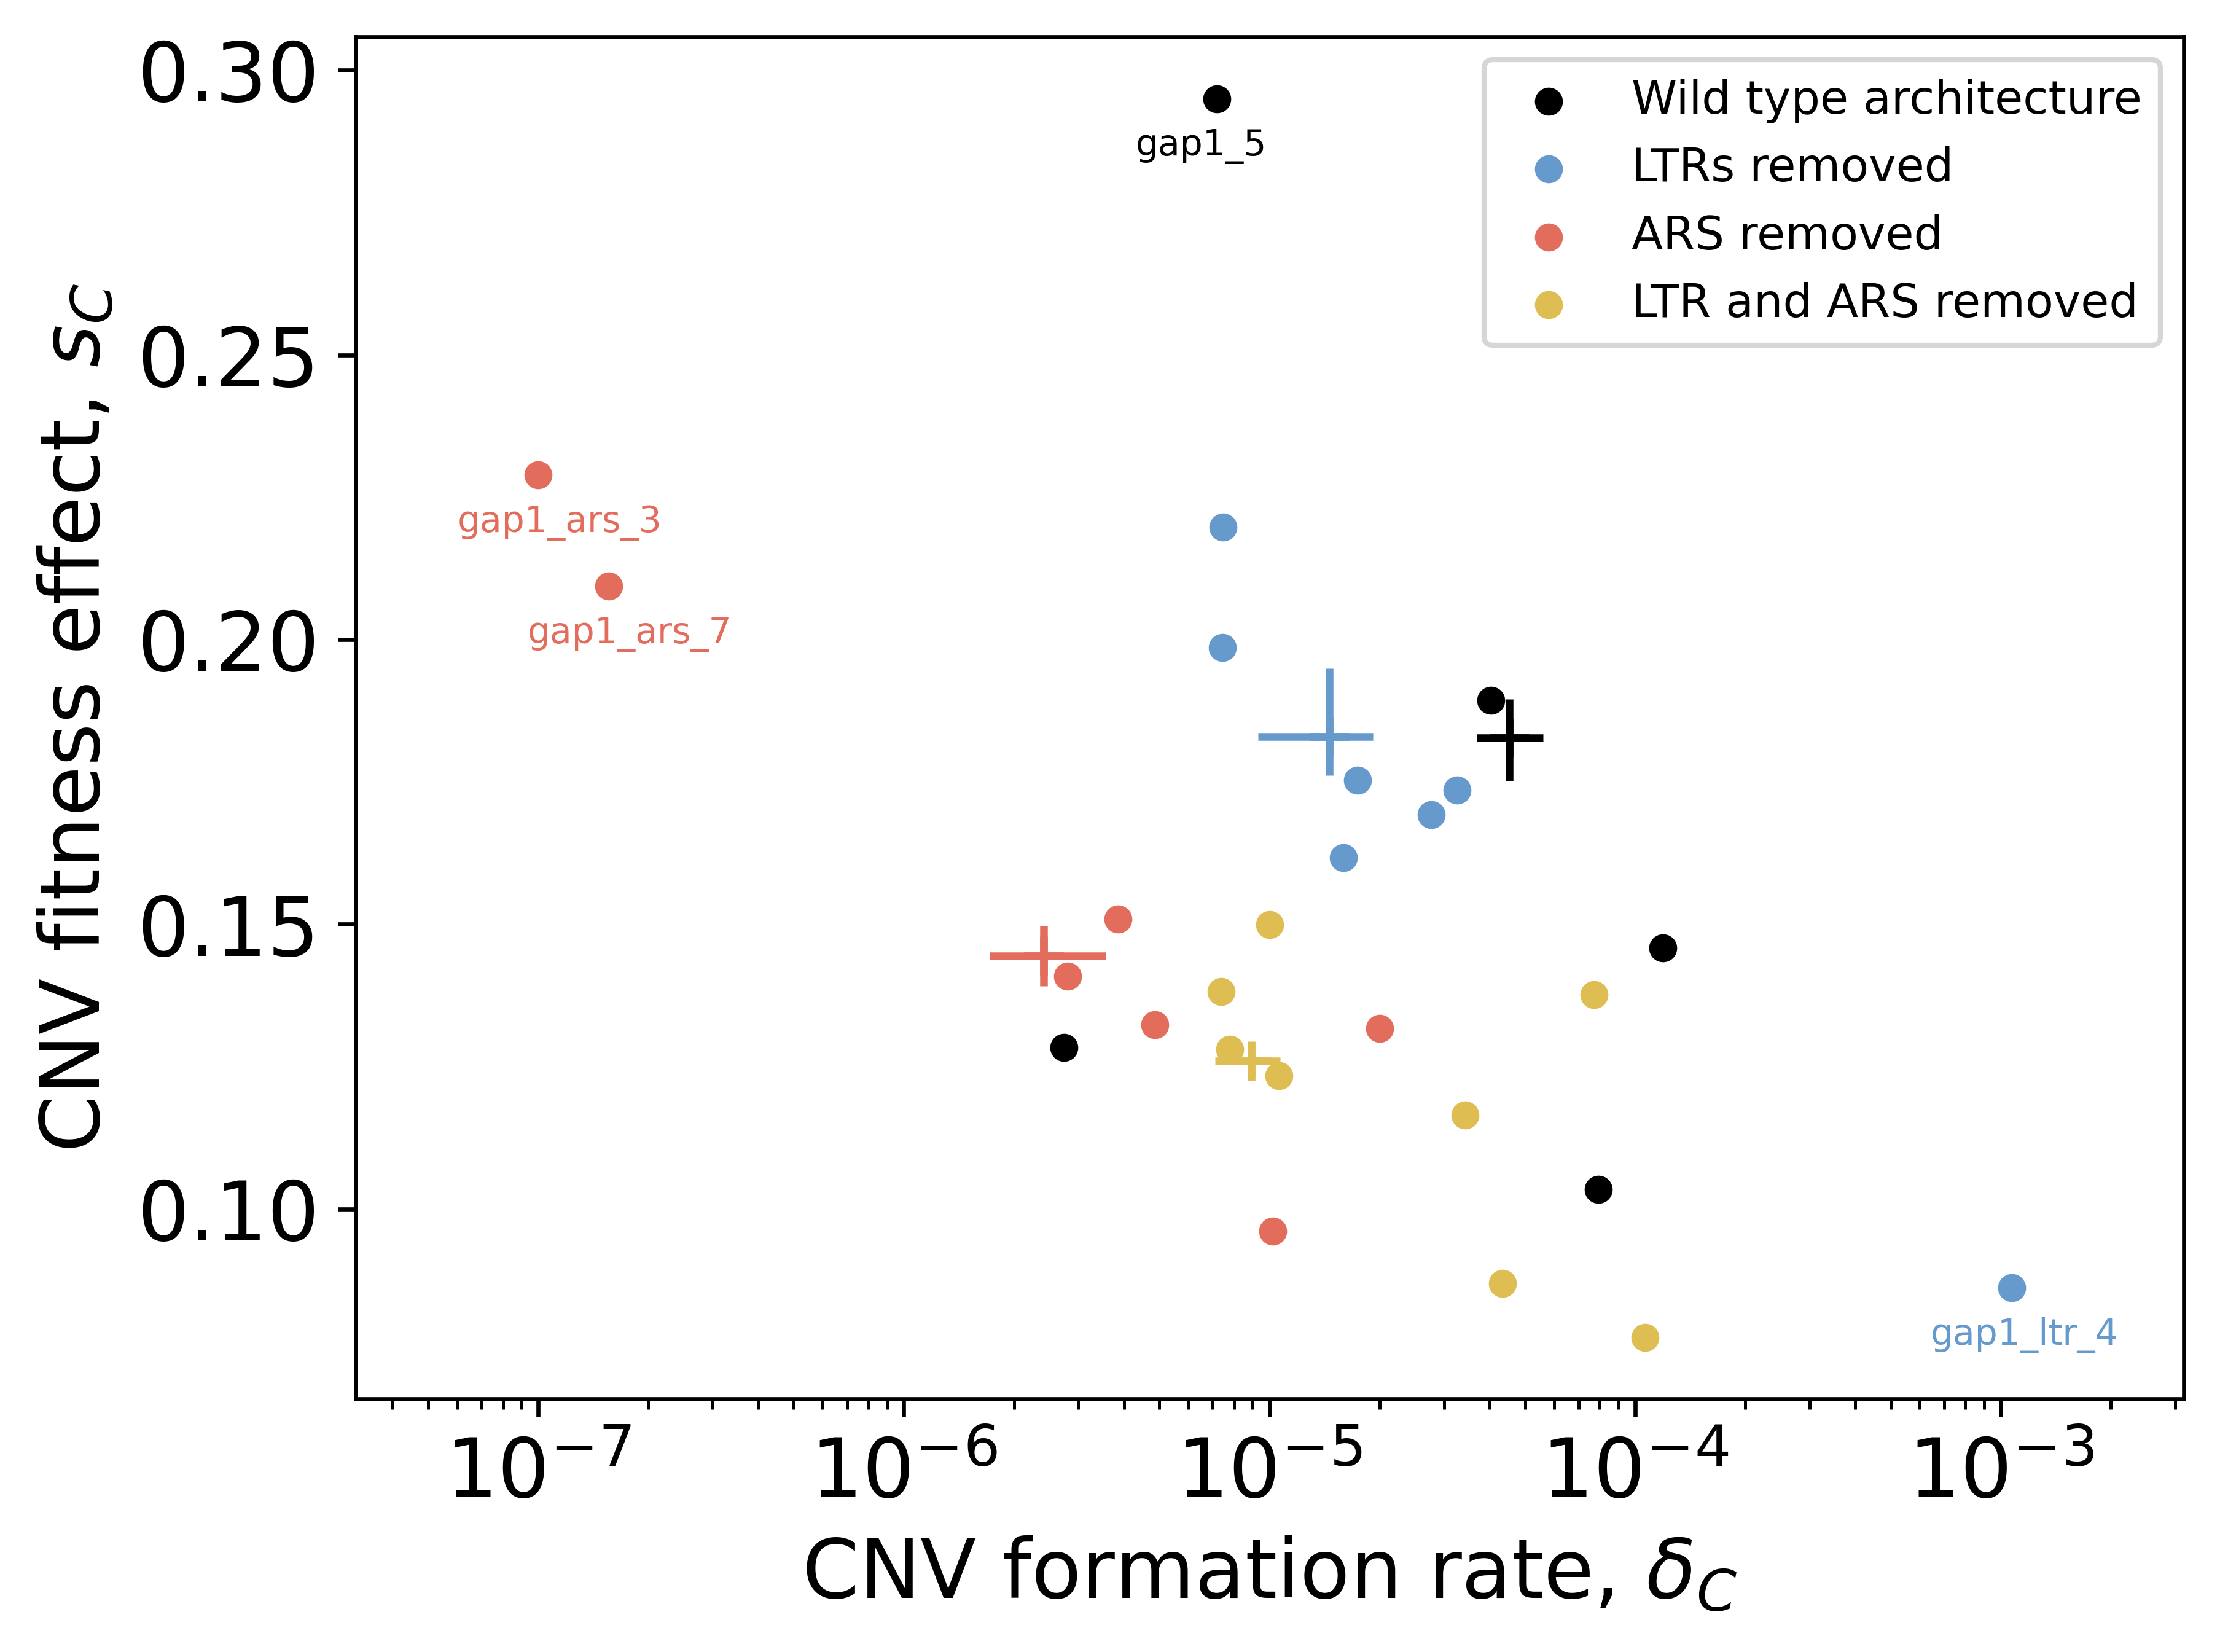

In [6]:
from seaborn import scatterplot

# Plot formation rate δc and fitness effect Sc for given MAPs
def plot_maps(ax, maps, lines, overall=False):
    for c in lines:
        if overall:
            all_d = maps[maps['line'] == c]
            ax.scatter(x=10**all_d['log(m_cnv)'].astype('float64'), y=10**all_d['log(s_cnv)'].astype('float64'),
                     color=rep_colors[c], s = 60, marker='+')
            
            # Add HDIs
            samples = overall_samples[overall_samples['line']==c]
            s, m = 10**np.array(samples.iloc[:,1]), 10**np.array(samples.iloc[:,2])
            ax.hlines(float(10**all_d['log(s_cnv)'].astype('float64')), xmin=np.quantile(m,0.025), xmax=np.quantile(m,0.975), color=rep_colors[c])
            ax.vlines(float(10**all_d['log(m_cnv)'].astype('float64')), ymin=np.quantile(s,0.025), ymax=np.quantile(s,0.975), color=rep_colors[c])

        else:
            all_d = maps[maps['line'] == c]
            ax.scatter(x=10**all_d['log(m_cnv)'].astype('float64'), y=10**all_d['log(s_cnv)'].astype('float64'),
                     color=rep_colors[c], s = 20, label = f'{label_dict[c]}', marker='o')

        ax.set_xlabel('CNV formation rate, $δ_C$')
        ax.set_ylabel('CNV fitness effect, $s_C$')
        # ax.set_yscale('log')
        ax.set_xscale('log')
        ax.legend(fontsize = 9)
        for i in range(len(all_d)):
            cur = all_d.iloc[i,:]
            if cur[2] > np.log10(0.25) or cur[3] > -3.5 or cur[3] < -6:
                ax.text(0.6*10**cur[3],10**cur[2]-0.01,cur.name, fontsize=7, color=rep_colors[c])

fig, ax = plt.subplots()
ax.set_xlim(10**-7.5, 10**-2.5)
change_font(10)
        
# Only Chuong
lines = ['wt', 'ltr', 'ars', 'all']
plot_maps(ax, maps_sbi, lines)
plot_maps(ax, overall_maps, lines,overall=True)

# Posterior Predictive Checks
### Simulating inferred parameters (MAP) in a WF model

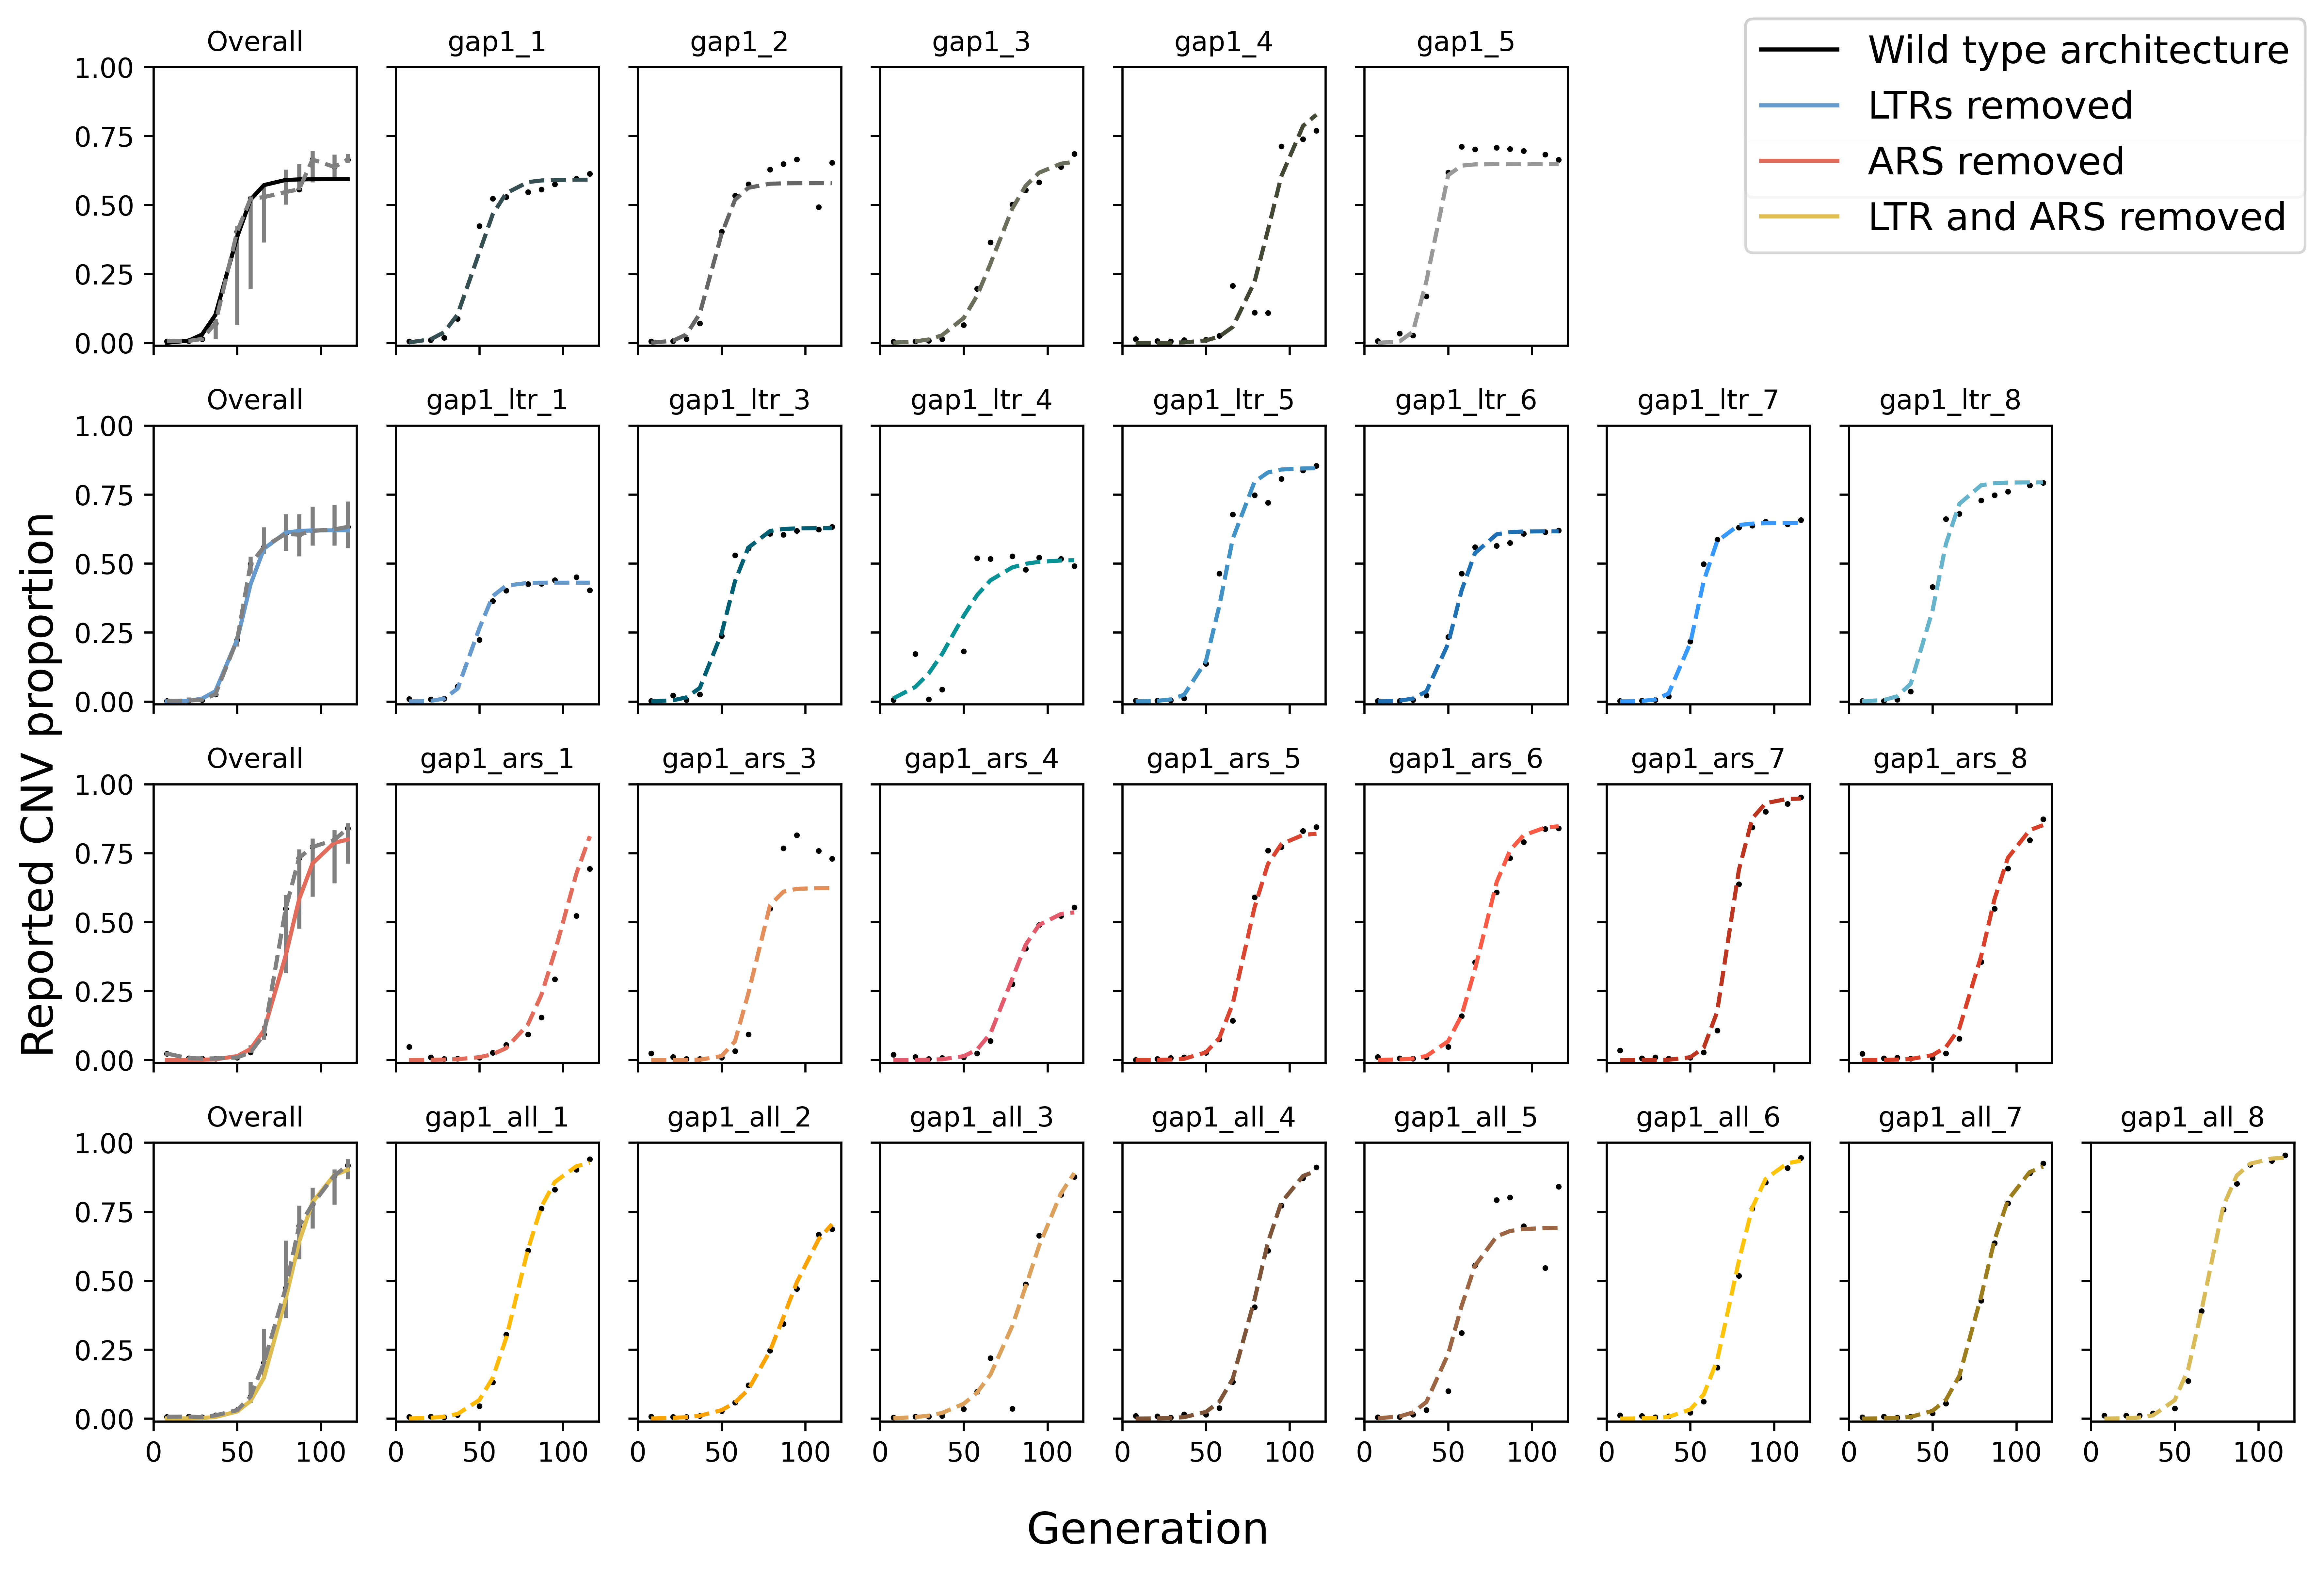

In [7]:
import pickle
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF
import torch

change_font(10)

# Simulation & model parameters
reps = 1
chuong_generation = pd.read_csv(f'Chuong_116_gens.txt', delimiter = ', ', engine='python')
chuong_generation = chuong_generation.columns.astype('int')
N = 3.3e8

# Simulator function - generates a posterior prediction given model parameters
def CNVsimulator(cnv_params, generation):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
        
    return states

# Plot posterior predictive checks of (approximate) MAP value
# MAP is obtained using sbi's method (Gradient Ascent)
# n_samples -> number of posterior sample to generate (to get a sense of posterior's variance)
def posterior_predictions(posterior, maps, lines, n_samples=0):
    fig, ax = plt.subplots(4,9, tight_layout=True, figsize=(12,8), sharex=True, sharey=True)
    for l in range(len(lines)):
        line = lines[l]
        n = len(read_empirical(line))
        for i in range(n):
            axx = ax[l,i+1]
            color = color_dict[line][i]
            generation = chuong_generation
            emp_x = read_empirical(line,clean=False).iloc[i,:]
            x = read_empirical(line,clean=False).iloc[i,:]
                    
            axx.scatter(generation, emp_x, color = 'k', s=1.2) # data points are scattered
            axx.set_title(f'{x.name}', fontsize=10)
            # axx.set_ylabel(f'CNV proportion')
            # axx.set_xlabel(f'Generation')
            axx.set_ylim(-0.01)

            single_params = torch.tensor(maps.loc[x.name, 'log(s_cnv)':'log(p_0)']) # sbi params
            pred = CNVsimulator(single_params, generation).T
            axx.plot(generation, pred, color = color, linestyle='--', linewidth=1.5) # posterior prediction is plotted

            axx.set_yticks([0,0.25,0.5,0.75,1])
            axx.set_xticks([0,50,100])

            # generate samples and report mean RMSE
            if n_samples != 0:
                potential_fn = posterior.potential_fn
                potential_fn.set_x(x)
                posterior_mcmc = MCMCPosterior(potential_fn, proposal = prior)
                samples = posterior_mcmc.set_default_x(x).sample((n_samples,))
                a=[]
                for j in range(n_samples):
                    axx.plot(generation, CNVsimulator(samples[j,:], generation).T, color = color, linewidth=0.5)
                    a.append(np.sqrt(((CNVsimulator(samples[j,:],generation)-np.array(x))**2).mean()))
                final_rmse = sum(a)/len(a)
                print(f'mean RMSE = {final_rmse}')
                
        # Overall MAP and CI
        axx = ax[l,0]
        axx.set_title('Overall', fontsize=10)
        axx.set_ylim(-0.01)
        
        # 50% CI
        emp_y, emp_25, emp_75 = read_empirical(line).median(), read_empirical(line).quantile(0.25), read_empirical(line).quantile(0.75)
        axx.errorbar(x=generation, y=emp_y, yerr=np.array([emp_y-emp_25, emp_75-emp_y]).reshape(2,len(emp_y)), color='grey', linestyle='--')
        # axx.fill_between(generation, emp_25, emp_75, color='grey')
        axx.scatter(generation, emp_y, color='k', s=1.2)
    
        single_params = torch.tensor(overall_maps.loc[line, 'log(s_cnv)':]) # sbi params
        pred = CNVsimulator(single_params, generation).T
        axx.plot(generation, pred, color = rep_colors[line], linestyle='-', linewidth=1.5, label=label_dict[line]) # posterior prediction is plotted

        axx.set_yticks([0,0.25,0.5,0.75,1])
        axx.set_xticks([0,50,100])
    
        if n < 8:
            for k in range(n+1,9):
                ax[l,k].axis('off')
        fig.legend(loc='upper right', fontsize=14)
        fig.supxlabel('Generation', fontsize=16)
        fig.supylabel('Reported CNV proportion', fontsize=16)
        
posterior_predictions(posterior_chuong,maps_sbi,lines=['wt','ltr','ars','all'])

## RMSEs

In [70]:
change_font(20)
rmse_df = pd.read_csv('maps/rmse_df.csv', index_col=0)
overall_rmse_df = pd.read_csv('overall_rmse_df.csv', index_col=0)
overall_rmse_avg_df = pd.read_csv('overall_rmse_avg_df.csv', index_col=0)

def plot_rmses(rmse_df, ax, legend=False):
    for i in range(len(rmse_df)):
        rep = rmse_df.index[i]
        line = rmse_df.iloc[i,1]
        rmse = rmse_df.iloc[i,0]
        ax.scatter(line, rmse, color=rep_colors[line])
        
        line_spec = rmse_df[rmse_df['line']==line]
        if rmse == line_spec['mean RMSE'].max() and len(line_spec) > 1:
            ax.scatter(line, rmse, color=rep_colors[line], label=label_dict[line])
            ax.text(lines.index(line)-0.1,rmse+0.005,rep, fontsize=16, color=rep_colors[line])
    
    if legend:
        ax.legend()

    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_xlim(-0.5,3.5)
    
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(28,8), sharey=True)
fig.supylabel('mean RMSE')

plot_rmses(rmse_df, ax[0], legend=True)
ax[0].set_title('Individual Posteriors on Replicates')
plot_rmses(overall_rmse_df, ax[1])
ax[1].set_title('Collective Posteriors on Replicates')
plot_rmses(overall_rmse_avg_df, ax[2])
ax[2].set_title('Collective Posteriors on Averages')

Text(0.5, 1.0, 'Collective Posteriors on Averages')

## Overall MAPs and empirical observations

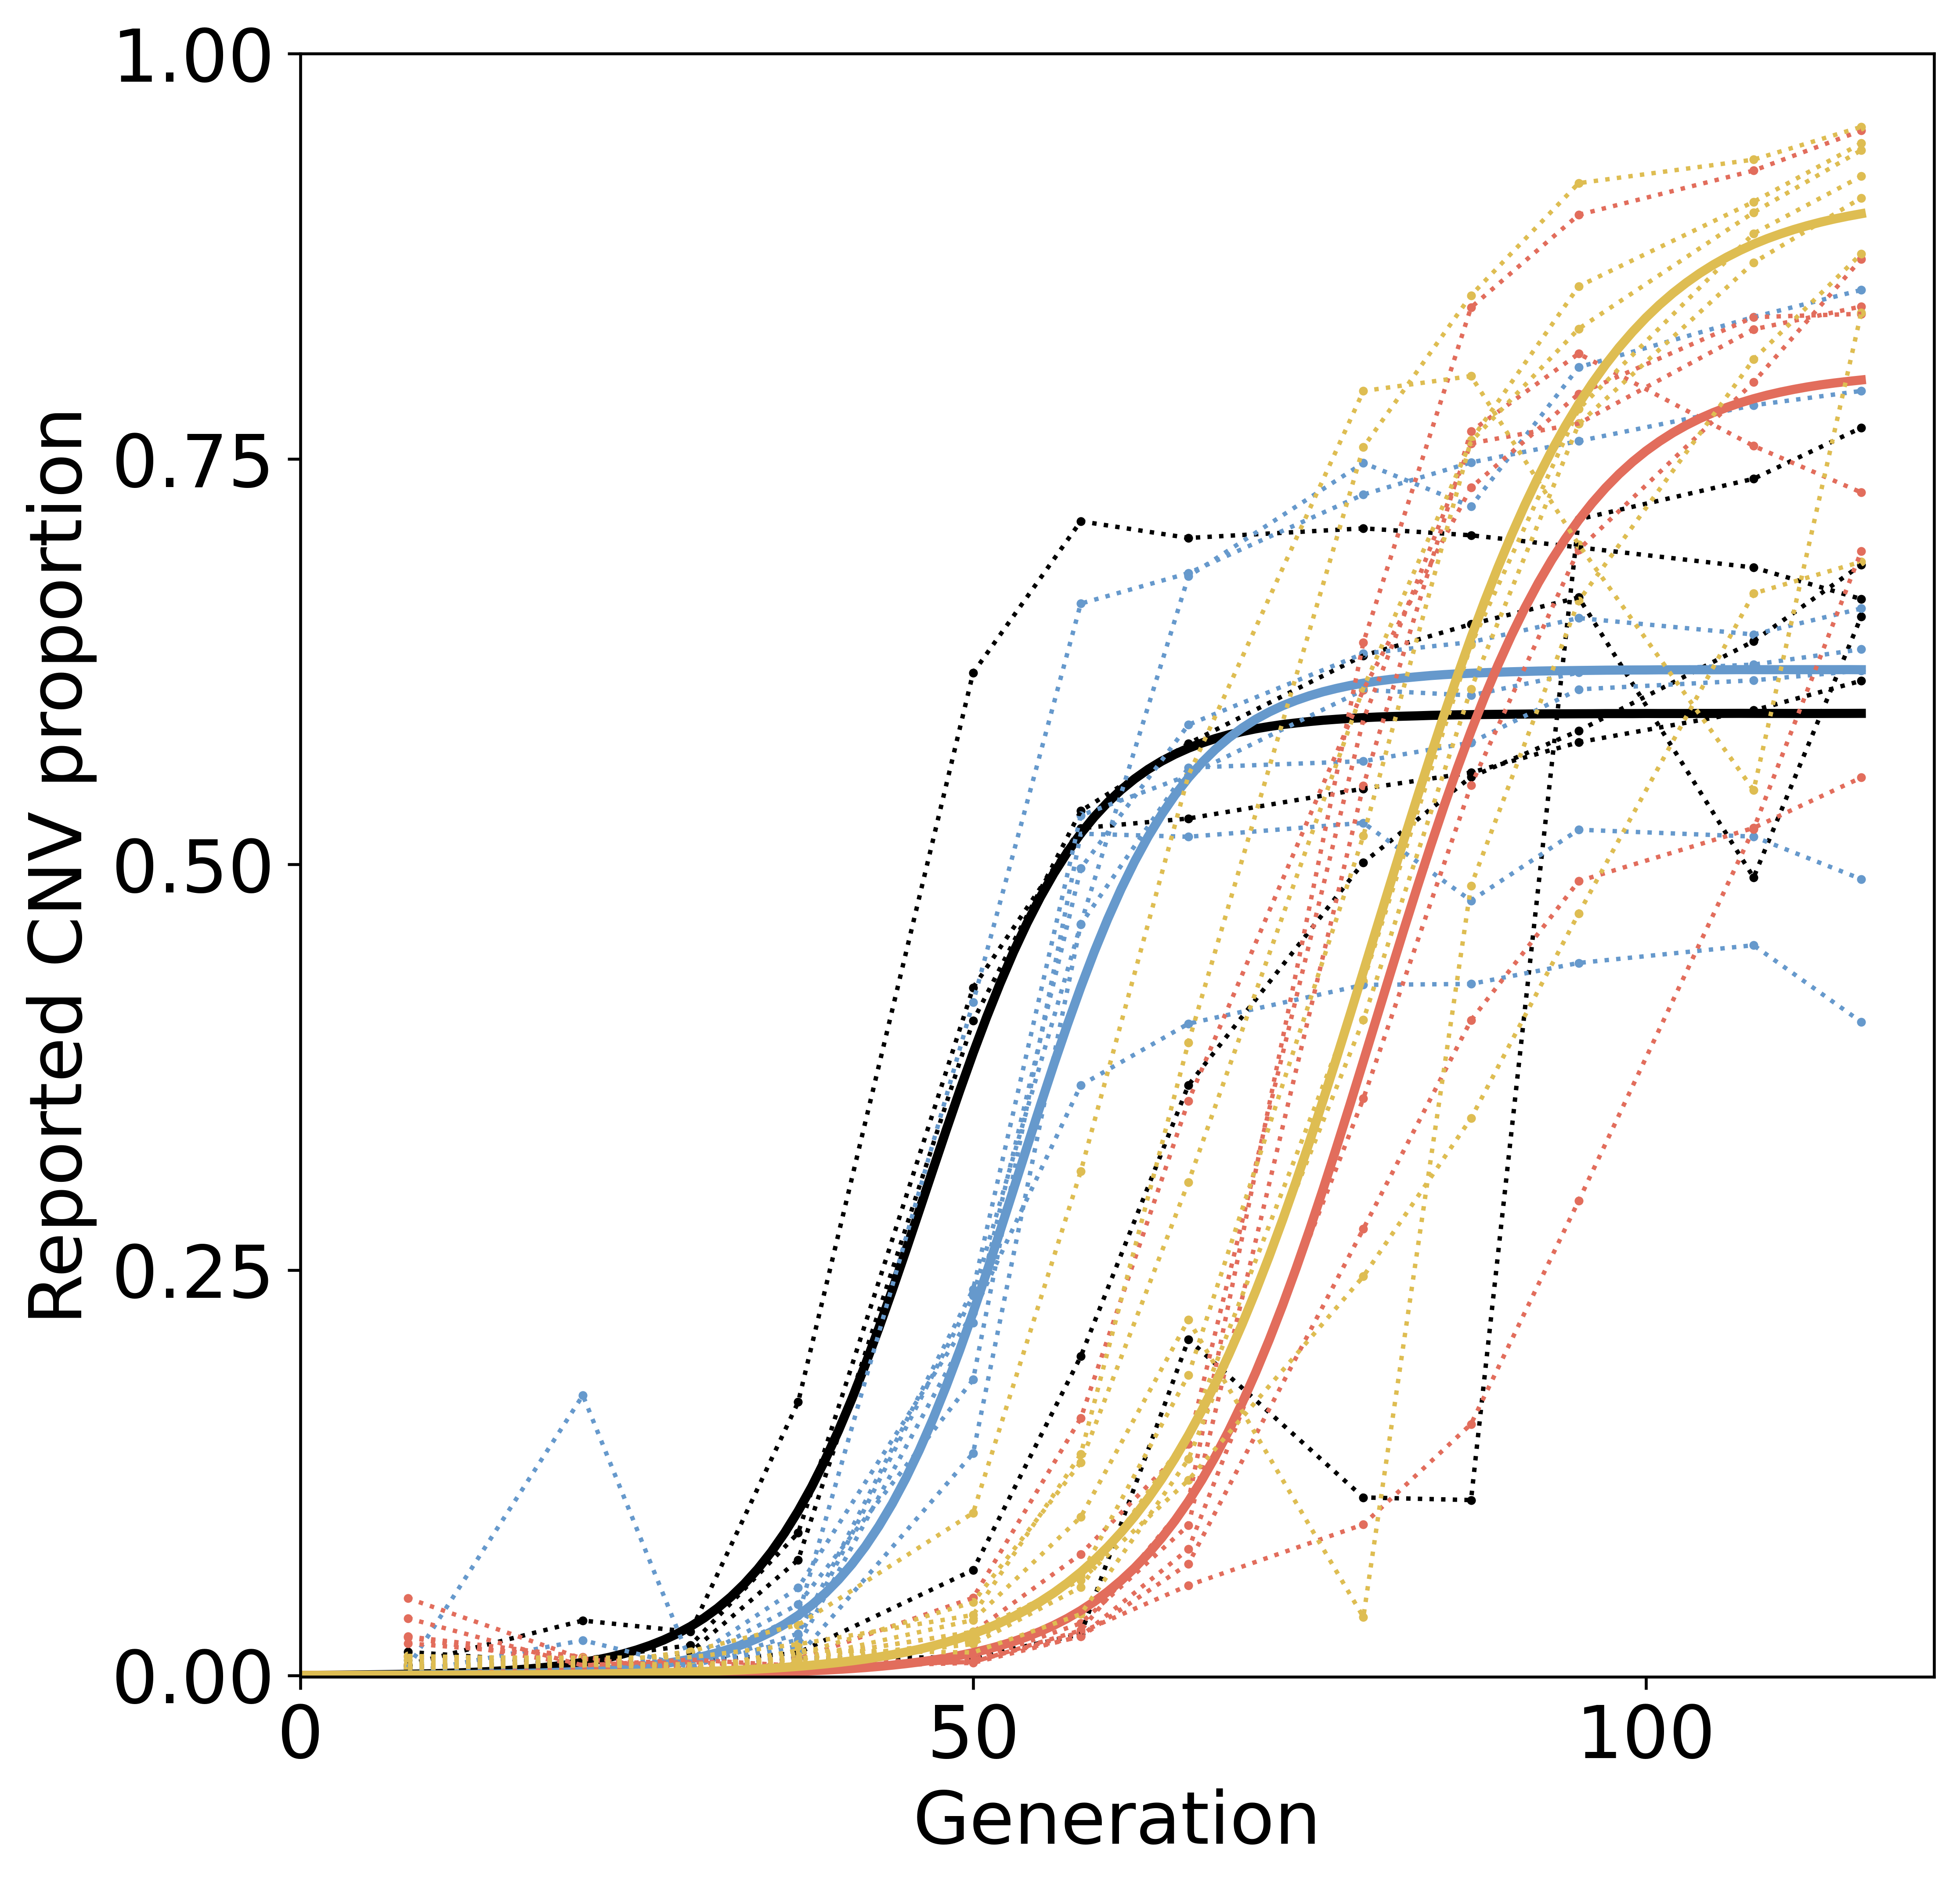

In [16]:
def posterior_predictions_main(maps, lines, n_samples=0):
    fig, ax = plt.subplots(figsize=(8,8))
    for l in range(len(lines)):
        line = lines[l]
        # fig.suptitle(f'{label_dict[line]}')
        n = len(read_empirical(line))
        for i in range(n):
            axx = ax
            color = rep_colors[line]
            x = read_empirical(line,clean=False).iloc[i,:]
            generation = chuong_generation
            emp_x = read_empirical(line,clean=False).iloc[i,:]
            x = read_empirical(line,clean=False).iloc[i,:]
            axx.plot(generation, emp_x, color = color, linewidth=1.2, linestyle='dotted') # data points are plotted
            axx.scatter(generation, emp_x, color = color, s=2) # data points are scattered

            axx.set_ylabel(f'Reported CNV proportion')
            axx.set_xlabel(f'Generation')
            axx.set_ylim(-0.001)
            axx.set_xlim(-0.001)
            axx.set_yticks([0,0.25,0.5,0.75,1])
            axx.set_xticks([0,50,100])

        # Overall MAP
        axx = ax
        full_gen = np.array([i for i in range(117)])
        single_params = torch.tensor(maps.loc[line, 'log(s_cnv)':]) # sbi params
        pred = CNVsimulator(single_params, generation=full_gen).T
        axx.plot(full_gen, pred, color = color, linestyle='-', linewidth=2.5, label=label_dict[line]) # posterior prediction is plotted
        
change_font(20)
posterior_predictions_main(overall_maps,lines=['wt','ltr','ars','all'])

# Total CNVs (Pre-existing + Reported)

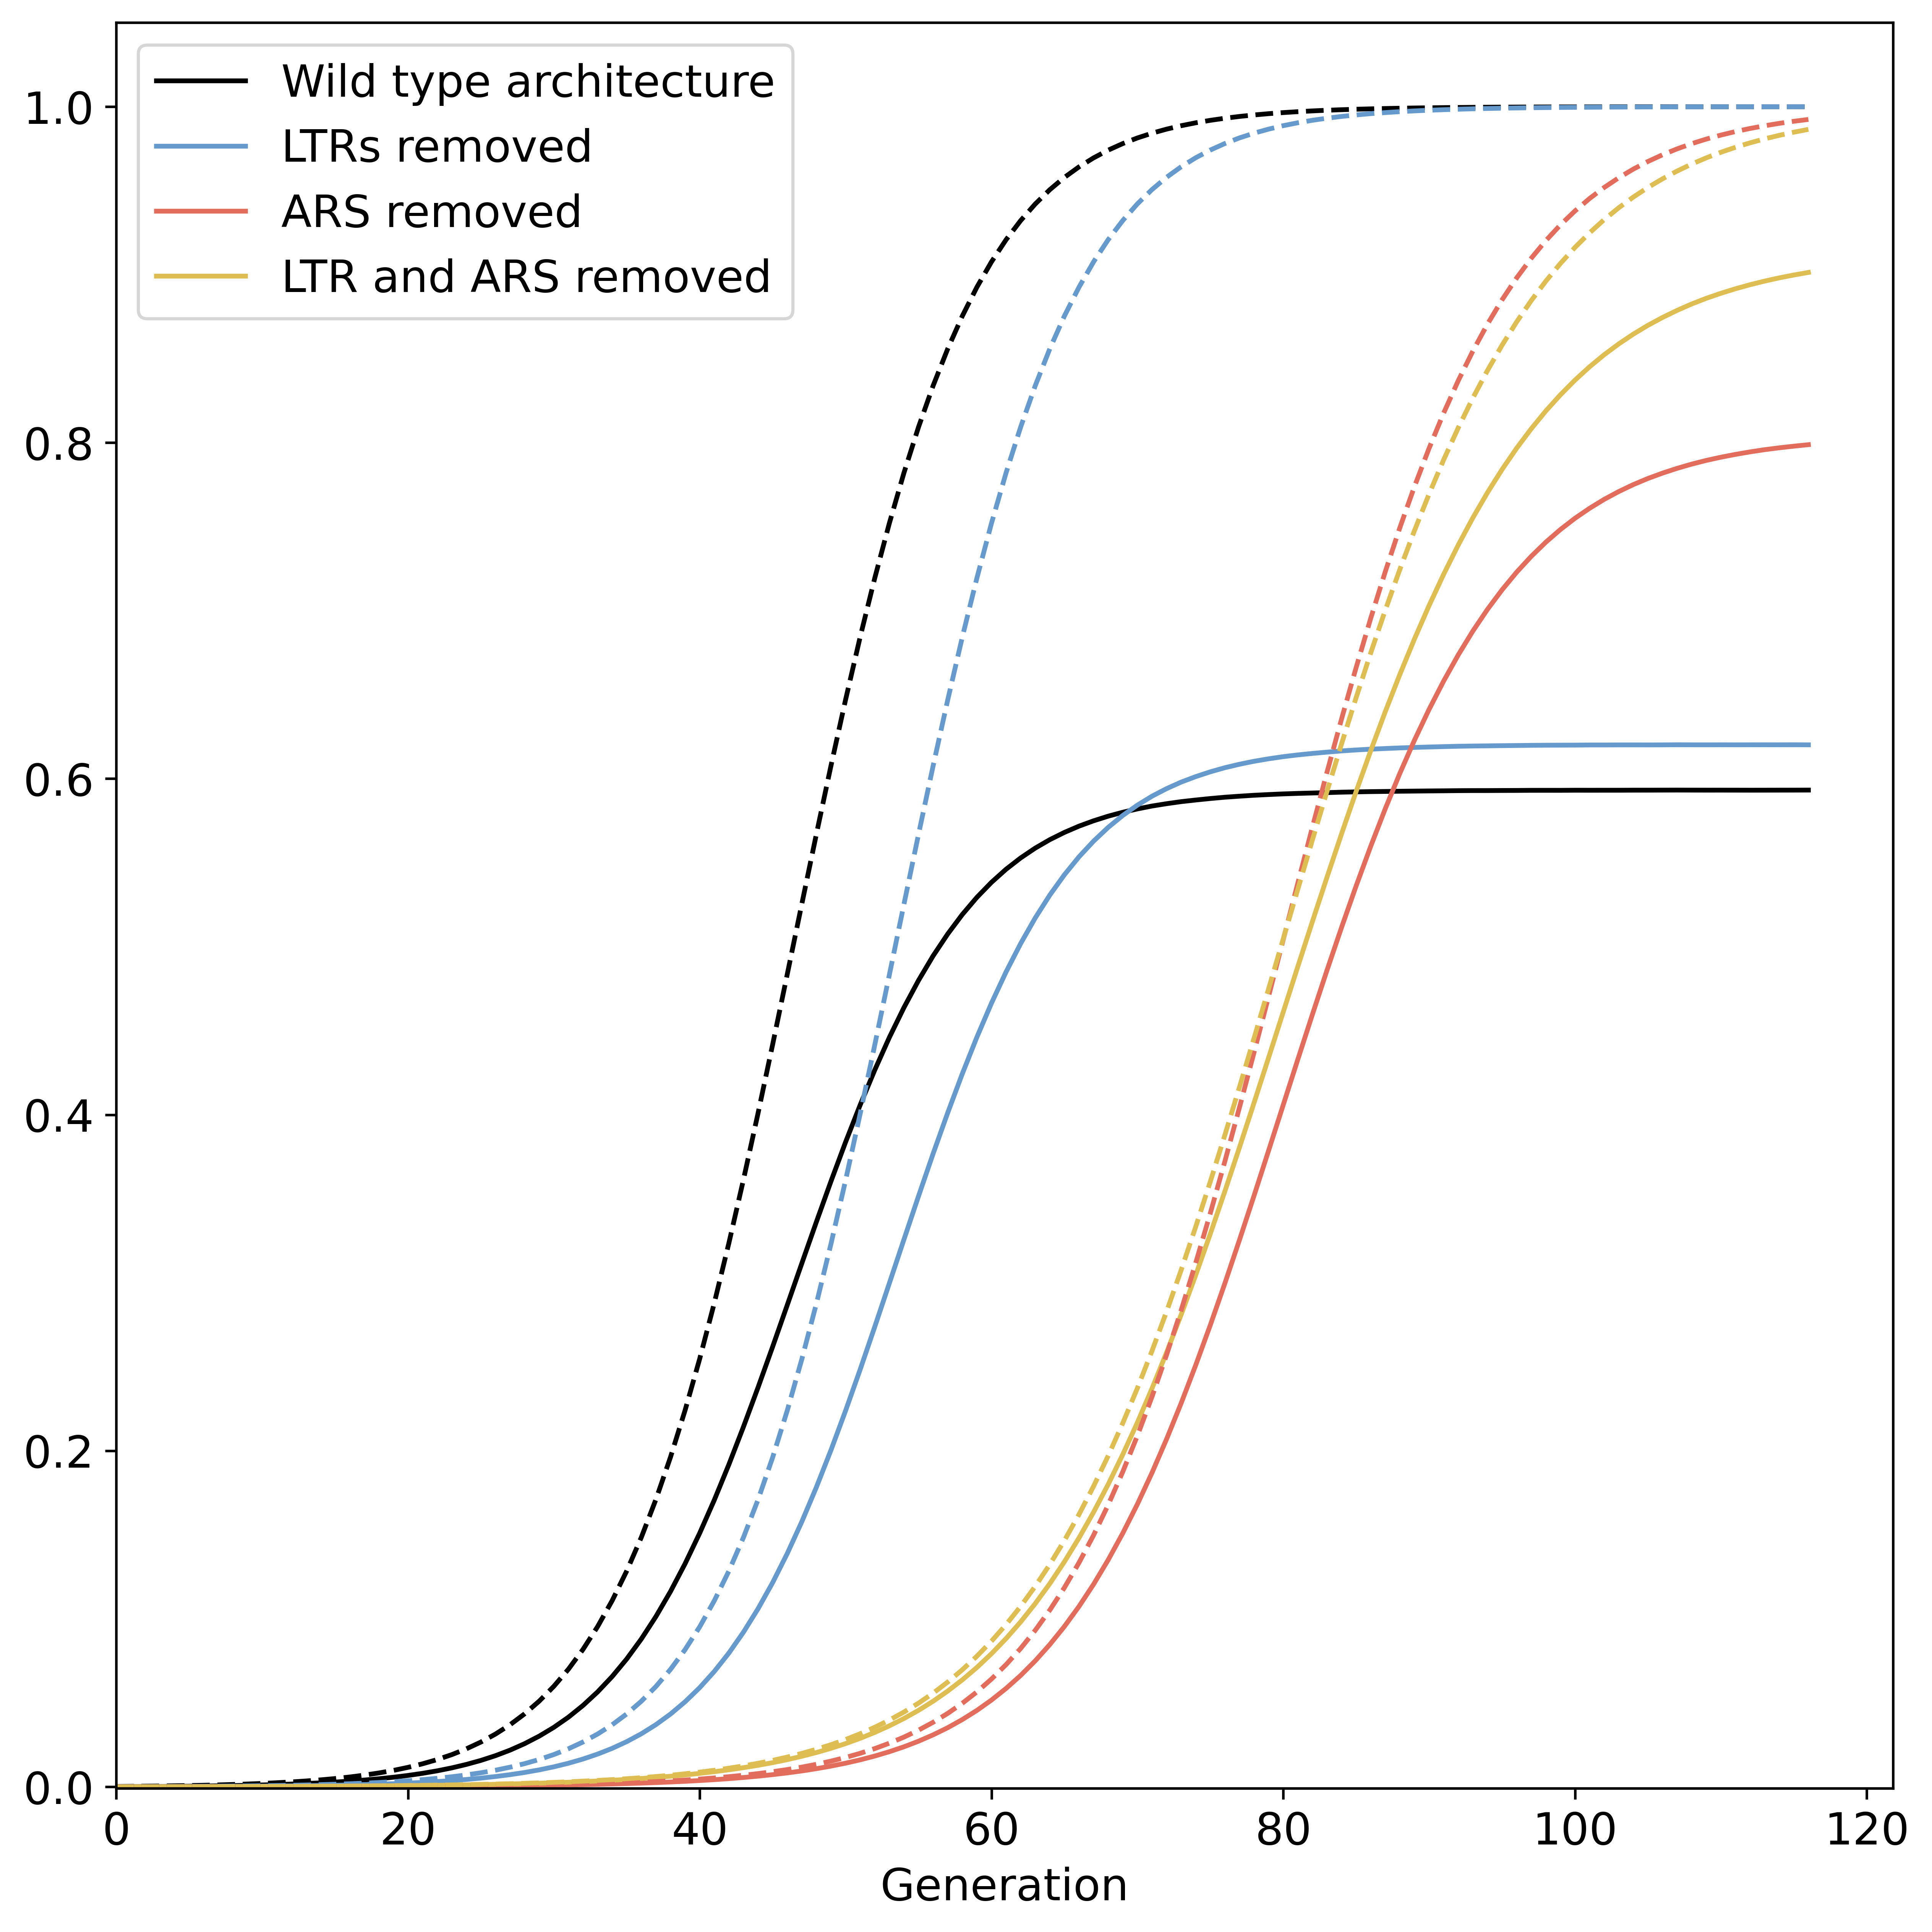

In [17]:
from total_cnvs import CNVsimulator_simpleWF as total_cnvs

change_font(14)

# Simulation & model parameters
reps = 1
gens = np.array([i for i in range(117)])
N = 3.3e8

# Simulator function - generates a posterior prediction given model parameters
def CNVsimulator(func,cnv_params, generation):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = func(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
        
    return states
fig, ax = plt.subplots(figsize=(10,10))
for line in ['wt', 'ltr', 'ars', 'all']:
    params = torch.tensor(overall_maps.loc[line,'log(s_cnv)':], dtype=torch.float)
    ax.plot(gens, CNVsimulator(CNVsimulator_simpleWF,params,gens).T, color=rep_colors[line], label=label_dict[line])

for line in ['wt', 'ltr', 'ars', 'all']:
    params = torch.tensor(overall_maps.loc[line,'log(s_cnv)':], dtype=torch.float)
    ax.plot(gens, CNVsimulator(total_cnvs,params,gens).T, linestyle='--', color=rep_colors[line])
ax.set_xlabel('Generation')
ax.set_ylim(-0.001)
ax.set_xlim(-0.001)
ax.legend()